# OLS Model: Ordinary Least Squares Regression

This is the simplest baseline model for predicting stock returns:

$$r_{i,t+1} = z_{i,t}^T \beta + \epsilon_{i,t+1}$$

Where:
- $z_{i,t}$ is the feature vector (16 stock features in this implementation)
- $\beta$ is the regression coefficient
- No regularization is used, directly minimizing the sum of squared residuals

**Note**: The paper mentions a 920-dimensional feature space (94 stock features × 8 macro variables + constant), but this implementation uses 16 stock features only due to data availability.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import sys
import os

# Import utility functions
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils import (
    load_data, 
    prepare_features_target, 
    calculate_r2_os, 
    build_portfolio_returns,
    calculate_prediction_metrics
)
from TimeBasedCV import TimeBasedCV

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")



✅ Libraries imported successfully!


## 1. Load Data



In [4]:
# Load data
df = load_data('ger_factor_data_from2003.csv')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['eom'].min()} to {df['eom'].max()}")
print(f"Number of stocks: {df['id'].nunique()}")
print(f"\nData columns:")
print(df.columns.tolist())
df.head()



Data shape: (604564, 23)
Date range: 2019-01-01 00:00:00 to 2024-11-01 00:00:00
Number of stocks: 13176

Data columns:
['id', 'eom', 'ret_1_0', 'ret_6_1', 'ret_12_1', 'chmom', 'rmax1_21d', 'rvol_21d', 'turnover_126d', 'std_turn', 'dolvol_126d', 'zero_trades_252d', 'bidaskhl_21d', 'me', 'beta_60m', 'betasq', 'ivol_capm_252d', 'year', 'month', 'sic2', 'ret_exc_lead1m', 'ret', 'ret_exc']


,id,eom,ret_1_0,ret_6_1,ret_12_1,chmom,rmax1_21d,rvol_21d,turnover_126d,std_turn,dolvol_126d,zero_trades_252d,bidaskhl_21d,me,beta_60m,betasq,ivol_capm_252d,year,month,sic2,ret_exc_lead1m,ret,ret_exc
0,10026,2019-01-01,0.052962,0.004556,-0.032149,-0.085111,0.120143,0.031862,3.762866,1.897606,1.050593e+07,0.0,0.001979,2.899156e+06,0.508698,0.258773,0.014725,2019,1,20,0.090999,0.052962,0.052962
1,10026,2019-02-01,0.090999,-0.102655,0.033947,-0.057052,0.025581,0.013958,3.867808,1.835486,1.094369e+07,0.0,0.000958,2.916624e+06,0.435416,0.189587,0.014170,2019,2,20,0.046858,0.090999,0.090999
2,10026,2019-03-01,0.046858,-0.008748,0.141374,0.094516,0.015892,0.009551,3.883463,1.797655,1.106891e+07,0.0,0.001112,2.988575e+06,0.432408,0.186976,0.014102,2019,3,20,-0.025225,0.046858,0.046858
3,10026,2019-04-01,-0.025225,0.122304,0.149007,0.174232,0.018453,0.011702,3.932980,1.899354,1.126940e+07,0.0,0.001210,2.957656e+06,0.371663,0.138133,0.014320,2019,4,20,0.020803,-0.025225,-0.025225
4,10026,2019-05-01,0.020803,0.066435,0.136209,0.115406,0.018392,0.010043,3.954691,1.837047,1.141572e+07,0.0,0.001342,3.026715e+06,0.361605,0.130758,0.013972,2019,5,20,0.005324,0.020803,0.020803


## 2. Prepare Features and Target Variable



In [23]:
# Prepare features and target
X, y, metadata, feature_names = prepare_features_target(df)

print(f"Number of features: {len(feature_names)}")
print(f"Number of samples: {len(X)}")
print(f"\nFeature list:")
print(feature_names)
print(f"\nTarget variable statistics:")
print(y.describe())



Number of features: 16
Number of samples: 604564

Feature list:
['ret_1_0', 'ret_6_1', 'ret_12_1', 'chmom', 'rmax1_21d', 'rvol_21d', 'turnover_126d', 'std_turn', 'dolvol_126d', 'zero_trades_252d', 'bidaskhl_21d', 'me', 'beta_60m', 'betasq', 'ivol_capm_252d', 'sic2']

Target variable statistics:
count    604564.000000
mean          0.003326
std           0.139609
min          -0.425032
25%          -0.052083
50%           0.003885
75%           0.052310
max           0.563692
Name: ret_exc_lead1m, dtype: float64


## 3. Set Up Time Series Cross-Validation



In [24]:
# Create time series cross-validation object
# Adjust based on data length: data spans ~6 years (2019-2024), using smaller train/validation/test periods
# Training period: 2 years (24 months), validation period: 6 months, test period: 6 months
cv = TimeBasedCV(
    train_period=24,   # 2-year training period
    val_period=6,      # 6-month validation period
    test_period=6,     # 6-month test period
    freq='months'
)

# Prepare data frame for CV (requires date column)
cv_df = metadata.copy()
cv_df['eom'] = pd.to_datetime(cv_df['eom'])

# # Set first split date (start after sufficient time from data start, ensure training data)
min_date = cv_df['eom'].min()
max_date = cv_df['eom'].max()

# Calculate available time range (months)
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1
print(f"Total time span: {total_months}  months ({min_date.date()} to {max_date.date()})")

# # Set first split date: start 2.5 years (30 months) after data start
# # So first training period starts from min_date, ends at min_date+24 months
first_split_date = (min_date + pd.DateOffset(months=30)).date()  # Training period 24 months + validation period 6 months
second_split_date = (min_date + pd.DateOffset(months=36)).date()  # Plus test period 6 months

print(f"First split date: {first_split_date}")
print(f"Second split date: {second_split_date}")

# Generate cross-validation folds
folds = cv.split(cv_df, first_split_date, second_split_date, date_column='eom', gap=0)

print(f"\nGenerated {len(folds)} cross-validation folds")




Total time span: 71  months (2019-01-01 to 2024-11-01)
First split date: 2021-07-01
Second split date: 2022-01-01
Train period: 2019-07-01 - 2021-07-01 ,val period: 2021-07-01 - 2022-01-01 , Test period 2022-01-01 - 2022-07-01 # train records 184419 ,# val records 53091 , # test records 55458
Train period: 2019-10-01 - 2021-10-01 ,val period: 2021-10-01 - 2022-04-01 , Test period 2022-04-01 - 2022-10-01 # train records 188377 ,# val records 54619 , # test records 55511
Train period: 2020-01-01 - 2022-01-01 ,val period: 2022-01-01 - 2022-07-01 , Test period 2022-07-01 - 2023-01-01 # train records 193202 ,# val records 55458 , # test records 55493
Train period: 2020-04-01 - 2022-04-01 ,val period: 2022-04-01 - 2022-10-01 , Test period 2022-10-01 - 2023-04-01 # train records 198473 ,# val records 55511 , # test records 55300


Train period: 2020-07-01 - 2022-07-01 ,val period: 2022-07-01 - 2023-01-01 , Test period 2023-01-01 - 2023-07-01 # train records 203973 ,# val records 55493 , # test records 54766
Train period: 2020-10-01 - 2022-10-01 ,val period: 2022-10-01 - 2023-04-01 , Test period 2023-04-01 - 2023-10-01 # train records 209002 ,# val records 55300 , # test records 54621
Train period: 2021-01-01 - 2023-01-01 ,val period: 2023-01-01 - 2023-07-01 , Test period 2023-07-01 - 2024-01-01 # train records 213534 ,# val records 54766 , # test records 54879
Train period: 2021-04-01 - 2023-04-01 ,val period: 2023-04-01 - 2023-10-01 , Test period 2023-10-01 - 2024-04-01 # train records 216814 ,# val records 54621 , # test records 55227
Train period: 2021-07-01 - 2023-07-01 ,val period: 2023-07-01 - 2024-01-01 , Test period 2024-01-01 - 2024-07-01 # train records 218808 ,# val records 54879 , # test records 55532
Train period: 2021-10-01 - 2023-10-01 ,val period: 2023-10-01 - 2024-04-01 , Test period 2024-04-01 

## 4. Train Model and Make Predictions



In [25]:
# Store all prediction results
all_predictions = []
all_actuals = []
all_dates = []
all_ids = []
# Store all model coefficients (for feature importance analysis)
all_coefficients = []

# Train and predict for each fold
for fold_idx, (train_idx, val_idx, test_idx) in enumerate(folds):
    print(f"\nProcessing fold {fold_idx + 1}/{len(folds)} ...")
    
    # Prepare training and test data
    X_train = X.iloc[train_idx].values
    y_train = y.iloc[train_idx].values
    X_test = X.iloc[test_idx].values
    y_test = y.iloc[test_idx].values
    
    # Standardize features (using training set mean and std)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train OLS model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Save coefficients (for feature importance analysis)
    all_coefficients.append(model.coef_.copy())
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Save results
    all_predictions.extend(y_pred)
    all_actuals.extend(y_test)
    all_dates.extend(metadata.iloc[test_idx]['eom'].values)
    all_ids.extend(metadata.iloc[test_idx]['id'].values)
    
    # Print performance for this fold
    r2_fold = calculate_r2_os(y_test, y_pred)
    print(f"    Fold R²_OS: {r2_fold:.4f}")

print(f"\n✅ Completed predictions for all folds!")
print(f"Total prediction samples: {len(all_predictions)}")



Processing fold 1/10 ...
    Fold R²_OS: -0.1251

Processing fold 2/10 ...


    Fold R²_OS: -0.1239

Processing fold 3/10 ...
    Fold R²_OS: -0.0114

Processing fold 4/10 ...
    Fold R²_OS: -0.0117

Processing fold 5/10 ...
    Fold R²_OS: 0.0080

Processing fold 6/10 ...
    Fold R²_OS: -0.0068

Processing fold 7/10 ...
    Fold R²_OS: 0.0001

Processing fold 8/10 ...
    Fold R²_OS: -0.0480

Processing fold 9/10 ...
    Fold R²_OS: 0.0197

Processing fold 10/10 ...
    Fold R²_OS: -0.0160

✅ Completed predictions for all folds!
Total prediction samples: 552772


## 5. Prediction Performance Metrics



In [26]:
# Calculate overall performance metrics
metrics = calculate_prediction_metrics(all_actuals, all_predictions)

print("=" * 50)
print("OLS Model Prediction Performance Metrics")
print("=" * 50)
for key, value in metrics.items():
    if isinstance(value, float):
        print(f"{key:20s}: {value:8.4f}")
    else:
        print(f"{key:20s}: {value}")
print("=" * 50)



OLS Model Prediction Performance Metrics
r2_os               :  -0.0234
mse                 :   0.0202
rmse                :   0.1422
mae                 :   0.0922
correlation         :   0.0219
mean_pred           :   0.0026
mean_true           :  -0.0014
std_pred            :   0.0244
std_true            :   0.1406
n_observations      : 552772


## 6. Build Portfolio and Calculate Returns



In [27]:
# Build portfolio returns
portfolio_df, summary_stats = build_portfolio_returns(
    all_actuals, 
    all_predictions, 
    all_dates, 
    all_ids, 
    n_deciles=10
)

print("\n" + "=" * 50)
print("Long-Short Portfolio Performance (OLS Model)")
print("=" * 50)
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 50)

# Display first few rows
portfolio_df.head(10)




Long-Short Portfolio Performance (OLS Model)
annual_return            :     0.2586
annual_volatility        :     0.2241
sharpe_ratio             :     1.1538
cumulative_return        :     0.8877
n_months                 : 33
mean_monthly_return      :     0.0215
std_monthly_return       :     0.0647


,date,long_short,decile_1,decile_2,decile_3,decile_4,decile_5,decile_6,decile_7,decile_8,decile_9,decile_10
0,2022-01-01,-0.001126,-0.001448,0.005054,0.003346,0.012210,0.021189,0.023354,0.020951,0.018361,0.018041,-0.002574
1,2022-02-01,0.037999,-0.005782,0.006278,0.033818,0.042767,0.046457,0.047301,0.042182,0.045050,0.031310,0.032216
2,2022-03-01,-0.187433,-0.010571,-0.027029,-0.039286,-0.054985,-0.074402,-0.087186,-0.097694,-0.124643,-0.162534,-0.198003
3,2022-04-01,-0.059122,-0.012591,-0.010452,-0.010002,-0.016927,-0.021336,-0.029820,-0.026798,-0.036530,-0.044727,-0.071713
4,2022-05-01,-0.082420,-0.005780,-0.041054,-0.059111,-0.068722,-0.078659,-0.084564,-0.095297,-0.092967,-0.091682,-0.088200
5,2022-06-01,0.019610,0.003576,0.023155,0.032293,0.046615,0.055276,0.059511,0.058075,0.055387,0.050102,0.023185
6,2022-07-01,0.002493,-0.001805,-0.013766,-0.019682,-0.018056,-0.017415,-0.017673,-0.012758,-0.013383,0.000230,0.000688
7,2022-08-01,-0.102193,-0.040576,-0.071043,-0.085017,-0.086793,-0.096843,-0.103664,-0.110997,-0.119911,-0.132178,-0.142769
8,2022-09-01,0.020516,-0.001782,0.019483,0.046693,0.050393,0.063535,0.069329,0.075166,0.064658,0.047974,0.018734
9,2022-10-01,0.040071,-0.051636,0.000551,0.014413,0.022905,0.018538,0.020704,0.015106,0.008840,0.015821,-0.011565


## 7. Feature Importance Analysis



OLS Model Feature Importance Analysis

Top 10 most important features:
----------------------------------------------------------------------
ret_12_1            : coefficient= -0.0201, importance=  0.0201
ret_6_1             : coefficient=  0.0122, importance=  0.0122
chmom               : coefficient=  0.0101, importance=  0.0101
std_turn            : coefficient= -0.0070, importance=  0.0070
rvol_21d            : coefficient= -0.0067, importance=  0.0067
sic2                : coefficient= -0.0065, importance=  0.0065
betasq              : coefficient= -0.0056, importance=  0.0056
beta_60m            : coefficient=  0.0052, importance=  0.0052
rmax1_21d           : coefficient=  0.0042, importance=  0.0042
ret_1_0             : coefficient=  0.0029, importance=  0.0029


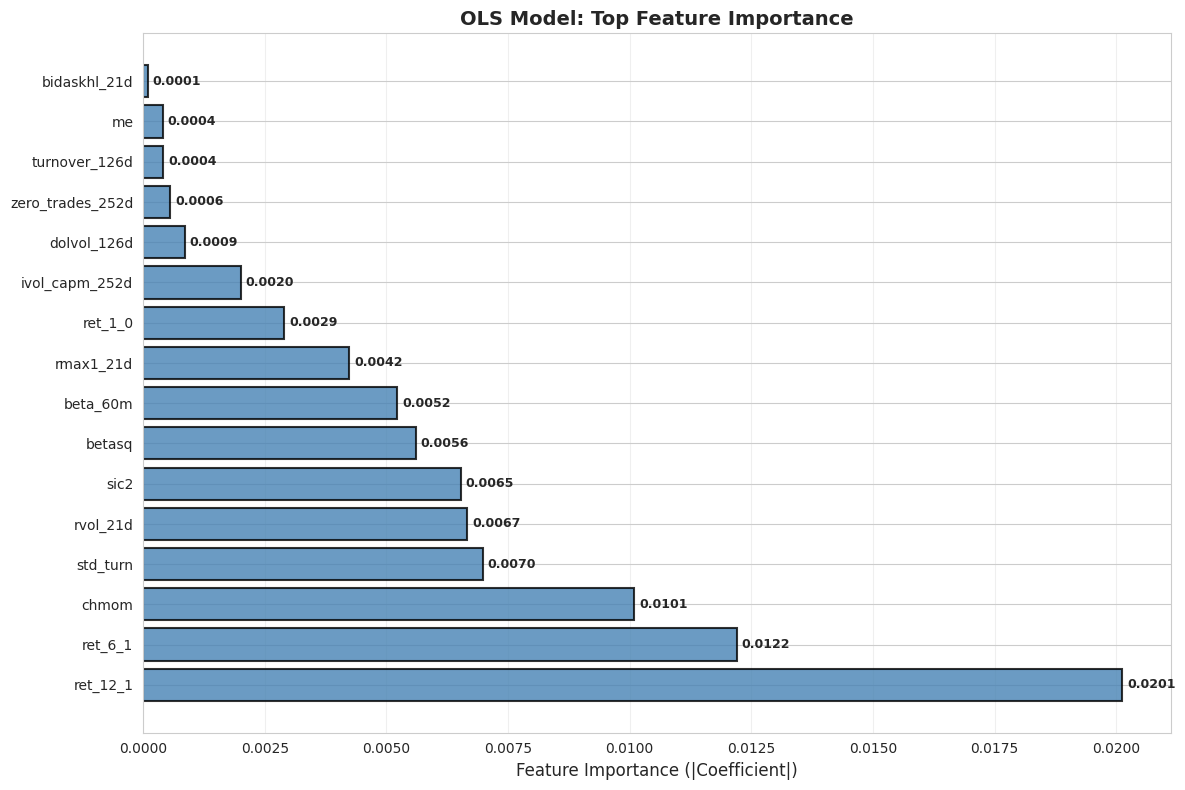

In [28]:
# Calculate feature importance (using absolute value of coefficients)
# Average coefficients across all folds, then take absolute value
coefficients_array = np.array(all_coefficients)
mean_coefficients = np.mean(coefficients_array, axis=0)
feature_importance = np.abs(mean_coefficients)

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': mean_coefficients,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("=" * 70)
print("OLS Model Feature Importance Analysis")
print("=" * 70)
print(f"\nTop 10 most important features:")
print("-" * 70)
for i, row in feature_importance_df.head(10).iterrows():
    print(f"{row['feature']:20s}: coefficient={row['coefficient']:8.4f}, importance={row['importance']:8.4f}")

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))
top_n = min(16, len(feature_importance_df))
top_features = feature_importance_df.head(top_n)
bars = ax.barh(range(len(top_features)), top_features['importance'].values, 
               color='steelblue', edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Feature Importance (|Coefficient|)', fontsize=12)
ax.set_title('OLS Model: Top Feature Importance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features['importance'].values)):
    ax.text(val + 0.0001, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Visualization Results



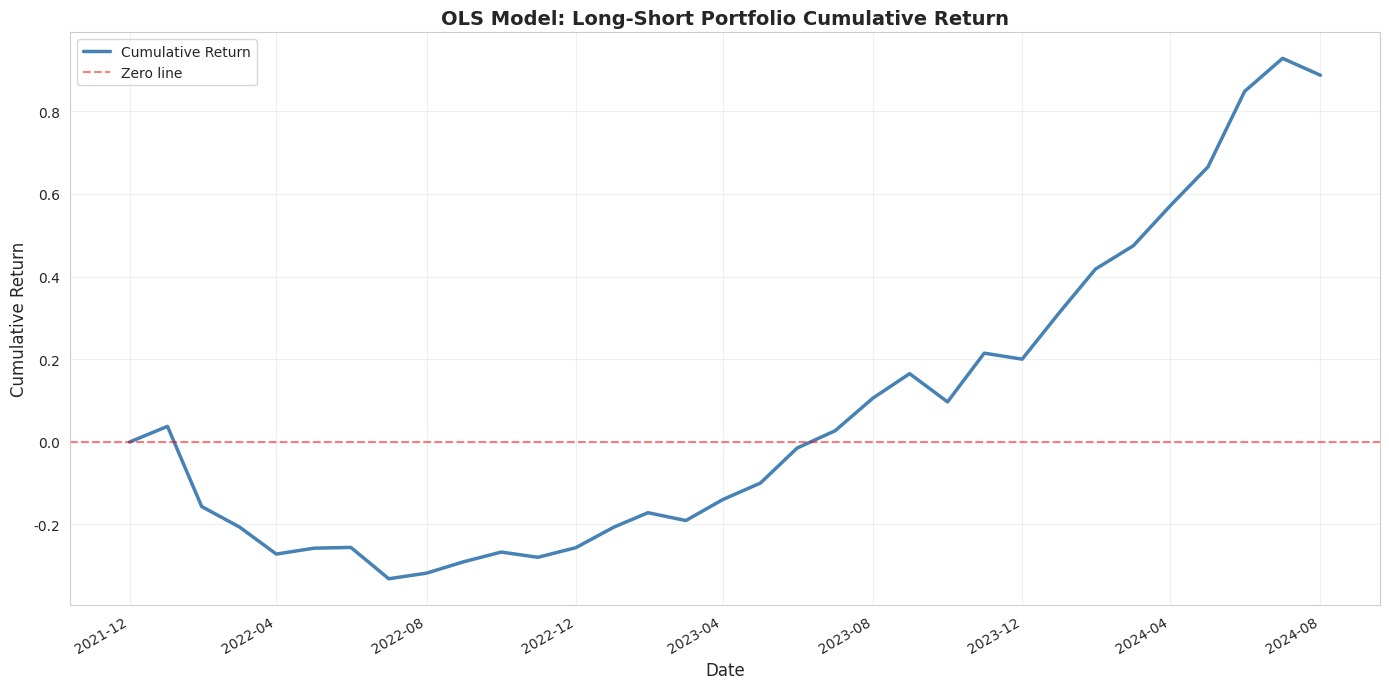


📊 Cumulative Return Statistics:
   Final Cumulative Return: 88.77%
   Max Drawdown: -36.93%


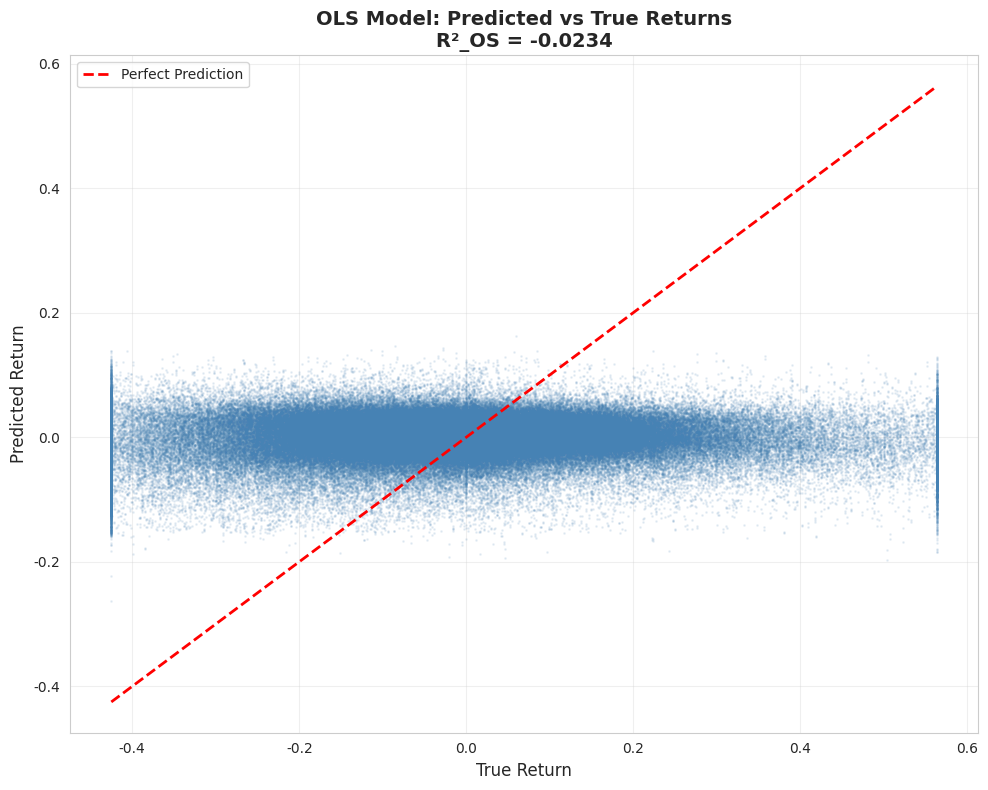

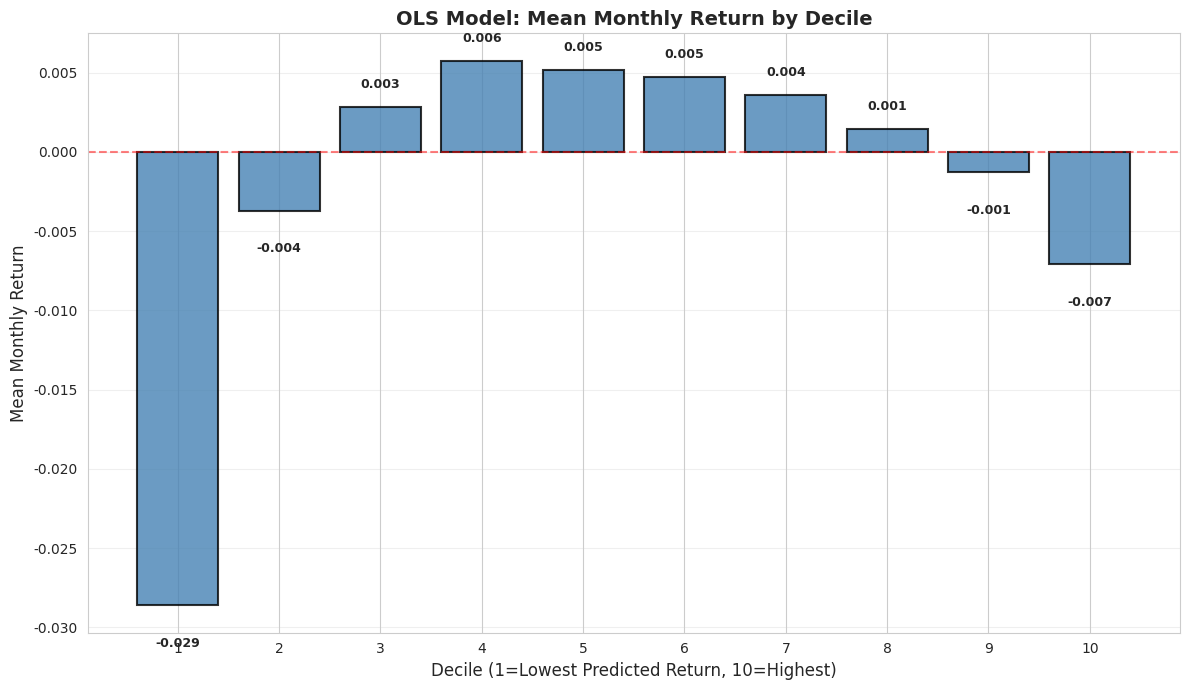


Decile Portfolio Returns Statistics
Decile  1:  -0.0286 ( -2.86%)
Decile  2:  -0.0037 ( -0.37%)
Decile  3:   0.0028 (  0.28%)
Decile  4:   0.0058 (  0.58%)
Decile  5:   0.0052 (  0.52%)
Decile  6:   0.0047 (  0.47%)
Decile  7:   0.0036 (  0.36%)
Decile  8:   0.0014 (  0.14%)
Decile  9:  -0.0013 ( -0.13%)
Decile 10:  -0.0071 ( -0.71%)
------------------------------------------------------------
Long-Short Spread (Decile 10 - Decile 1): 0.0215 (2.15%)


In [29]:
# Set matplotlib font settings
import matplotlib
import warnings

# Suppress font warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

# Set default font
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']
matplotlib.rcParams['axes.unicode_minus'] = False

# 1. Cumulative return curve
if 'long_short' in portfolio_df.columns:
    portfolio_df['cumulative_return'] = (1 + portfolio_df['long_short']).cumprod() - 1
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(portfolio_df['date'], portfolio_df['cumulative_return'], linewidth=2.5, color='steelblue', label='Cumulative Return')
    ax.set_title('OLS Model: Long-Short Portfolio Cumulative Return', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Return', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Zero line')
    ax.legend(fontsize=10)
    fig.autofmt_xdate()  # Auto-format dates
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Cumulative Return Statistics:")
    print(f"   Final Cumulative Return: {portfolio_df['cumulative_return'].iloc[-1]:.2%}")
    print(f"   Max Drawdown: {(portfolio_df['cumulative_return'] - portfolio_df['cumulative_return'].cummax()).min():.2%}")

# 2. Predicted vs True Returns Scatter Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(all_actuals, all_predictions, alpha=0.1, s=1, color='steelblue')
ax.plot([np.min(all_actuals), np.max(all_actuals)], 
         [np.min(all_actuals), np.max(all_actuals)], 
         'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('True Return', fontsize=12)
ax.set_ylabel('Predicted Return', fontsize=12)
ax.set_title(f'OLS Model: Predicted vs True Returns\nR²_OS = {metrics["r2_os"]:.4f}', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Decile Portfolio Returns Comparison
if len([col for col in portfolio_df.columns if col.startswith('decile_')]) > 0:
    decile_cols = [col for col in portfolio_df.columns if col.startswith('decile_')]
    decile_means = portfolio_df[decile_cols].mean()
    
    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.bar(range(1, len(decile_means) + 1), decile_means.values, 
                   color='steelblue', edgecolor='black', linewidth=1.5, alpha=0.8)
    ax.set_title('OLS Model: Mean Monthly Return by Decile', fontsize=14, fontweight='bold')
    ax.set_xlabel('Decile (1=Lowest Predicted Return, 10=Highest)', fontsize=12)
    ax.set_ylabel('Mean Monthly Return', fontsize=12)
    ax.set_xticks(range(1, len(decile_means) + 1))
    ax.set_xticklabels(range(1, len(decile_means) + 1))
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, decile_means.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.002),
                f'{val:.3f}', ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print decile return statistics
    print("\n" + "=" * 60)
    print("Decile Portfolio Returns Statistics")
    print("=" * 60)
    for i, (decile, ret) in enumerate(decile_means.items(), 1):
        print(f"Decile {i:2d}: {ret:8.4f} ({ret*100:6.2f}%)")
    print("-" * 60)
    ls_spread = decile_means.iloc[-1] - decile_means.iloc[0]
    print(f"Long-Short Spread (Decile 10 - Decile 1): {ls_spread:.4f} ({ls_spread*100:.2f}%)")
    print("=" * 60)

## Results Summary and Interpretation

### Key Findings:

**1. Dataset:**
- 604,564 observations with 16 features
- Time period: January 2019 to November 2024
- 13,176 unique stocks
- Note: Current dataset contains 16 stock features only, not the full 920-dimensional feature space (94 stock features × 8 macro variables + constant) mentioned in the paper

**2. Cross-Validation Setup:**
- 10-fold time series cross-validation
- Training period: 24 months, Validation period: 6 months, Test period: 6 months
- Time windows roll from July 2021 to October 2024
- Total of 552,772 out-of-sample predictions

**3. Model Performance:**
- **R²_OS = -0.0234**: Negative out-of-sample R² indicates weak predictive power, which is common in asset pricing as predicting stock returns is extremely challenging
- **Correlation = 0.0219**: Small but potentially statistically significant correlation between predicted and actual returns
- **RMSE = 0.1422**: Relatively large prediction error, consistent with expectations for a baseline model
- **Prediction std (0.0244) << True return std (0.1406)**: Model predictions are overly conservative, showing much less variation than actual returns
- **Why negative R²_OS?**: R²_OS = 1 - (SSE_model / SSE_baseline). When model predictions are worse than simple historical average, R²_OS < 0. This is normal for baseline models in asset pricing.

**4. Portfolio Performance:**
- **Annual Return: 25.86%**: Strong performance over the test period
- **Sharpe Ratio: 1.15**: Good risk-adjusted returns
- **Cumulative Return: 88.77%**: Excellent performance over 33 months of testing
- **Key Insight**: Despite negative R²_OS, the portfolio is profitable, demonstrating that ranking ability matters more than absolute prediction accuracy

**5. Why Portfolio Profits Despite Negative R²_OS?**
- **Ranking Ability**: Although absolute predictions are inaccurate, the model correctly ranks stocks (distinguishing high vs. low return stocks)
- **Long-Short Strategy**: Going long on stocks with high predicted returns and short on stocks with low predicted returns
- **Equal-Weighted Portfolios**: Risk diversification improves stability
- **Long-Short Spread: 2.15%**: Monthly spread between top and bottom deciles demonstrates the model's ranking power

**6. Feature Importance:**
- Top features: `ret_12_1` (12-month momentum, coefficient = -0.0201), `ret_6_1` (6-month momentum, 0.0122), `chmom` (change in momentum, 0.0101)
- Momentum and volatility-related features dominate the model

### Interpretation:

The OLS model serves as a baseline for comparison with more sophisticated machine learning models. While it shows weak predictive power in terms of R²_OS, it demonstrates that even simple linear models can generate profitable trading strategies through proper ranking of stocks. The negative R²_OS is expected for a baseline model and highlights the difficulty of stock return prediction. The strong portfolio performance (25.86% annual return, Sharpe ratio 1.15) suggests that the model captures some cross-sectional patterns in stock returns, even if absolute predictions are inaccurate.

**Note**: This baseline model uses only 16 features. The full model in the paper uses 920 dimensions (interactions between 94 stock features and 8 macro variables), which may improve performance. Subsequent machine learning models (neural networks, transformers) are expected to outperform this baseline.